In [16]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import scipy.ndimage as spi
import os
import pandas as pd
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.visualization import SqrtStretch, imshow_norm, LogStretch, ZScaleInterval
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder
from astropy.nddata import Cutout2D
from skimage import restoration
import astropy as astro
from astropy.io import fits
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pylab as pylab
import astropy.units as u
plt.style.use("science")
params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (10, 10),
         'axes.labelsize': 25,
         'axes.titlesize':25,
         'xtick.labelsize':25,
         'ytick.labelsize':25,
        'xtick.major.size': 8,
        'xtick.minor.size': 4,
        'xtick.major.width': 1,
        'xtick.minor.width': 1,
        'ytick.major.size': 8,
        'ytick.minor.size': 4,
        'ytick.major.width': 1,
        'ytick.minor.width': 1,
        'font.size': 15 # for annotate
         }
pylab.rcParams.update(params)


In [6]:
datapath = "/media/alexandre/Seagate/Data/RXJ1131/hst_mos_0043768_acs_wfc_f814w_drz.fits"
data = fits.open(datapath)

In [7]:
# multiply the image by the weight so unit is now in Electron Count instead of Electron/s
exptime = data["PRIMARy"].header["EXPTIME"]
print(f"exposure time: {exptime} s")
image = data["SCI"].data * exptime #* data["WHT"].data / data["WHT"].data.sum()
weights = data["WHT"].data

exposure time: 1980.0 s


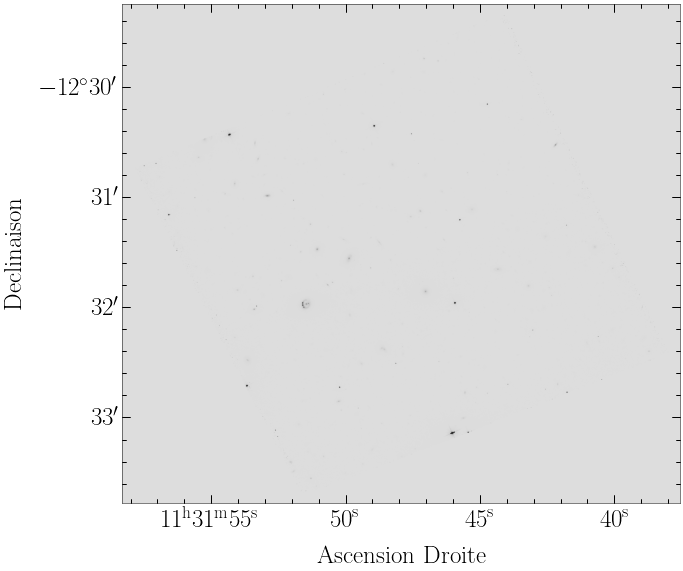

In [22]:
wcs = WCS(data["SCI"].header)
plt.figure(figsize=(10, 10))
plt.subplot(projection=wcs)
plt.imshow(image, cmap="gray_r", norm=ImageNormalize(interval=ZScaleInterval(), stretch=LogStretch()))

ax = plt.gca()
ax.set_xlabel('Ascension Droite')
ax.set_ylabel('Declinaison');

In [9]:
centroid = SkyCoord(172.96435966, -12.53284896, unit="deg")
centroid = centroid.to_pixel(wcs)
centroid

(array(2511.43624434), array(2705.39444813))

In [10]:
size = 175 * u.pixel
cutout = Cutout2D(image, centroid, size, wcs=wcs)
cutout_image = cutout.data
wcs_cutout = cutout.wcs
cutout_image[cutout_image < 0] = 0

In [11]:
cutout = Cutout2D(weights, centroid, size, wcs=wcs)
cutout_weights = cutout.data

In [12]:
mean, median, std = sigma_clipped_stats(cutout_image,  sigma=3.0)
print(mean, median, std)
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
sources = daofind(cutout_image)
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
center = 4

object_positions = sources[[7, 3, 1, 5, 4, 6]]["xcentroid", "ycentroid"].to_pandas().to_numpy() # B, A, C, D, G, S
ox, oy = object_positions[:, 0], object_positions[:, 1]

225.2698974609375 134.15936279296875 206.12289428710938


/home/alexandre/anaconda3/lib/python3.8/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/home/alexandre/anaconda3/lib/python3.8/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/home/alexandre/anaconda3/lib/python3.8/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/home/alexandre/anaconda3/lib/python3.8/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/home/alexandre/anaconda3/lib/python3.8/site-packages/matplotlib/ticker.py:2789: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


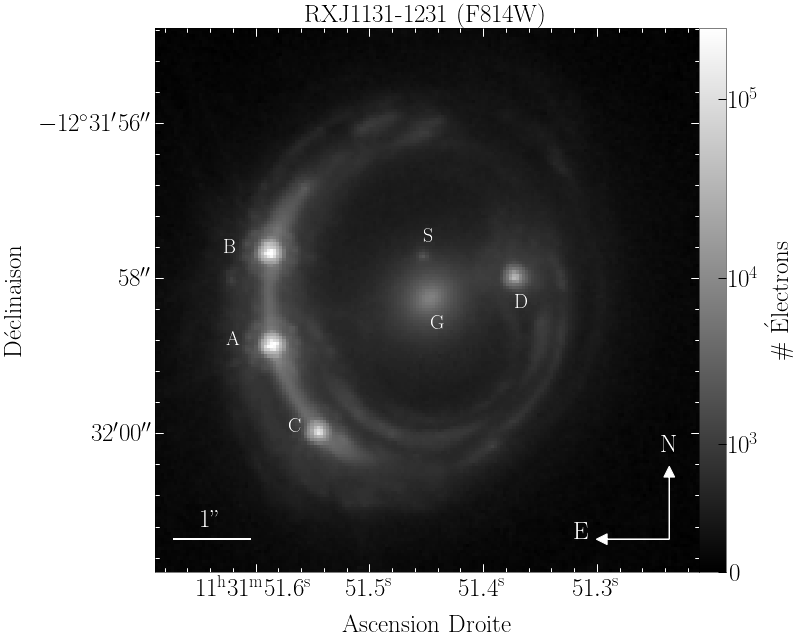

In [97]:
color = "w"
fig = plt.figure(figsize=(12, 10))
ax = plt.subplot(projection=wcs_cutout)
im = plt.imshow(cutout_image, cmap="gray", norm=ImageNormalize(stretch=LogStretch(a=1e3)))

ax.annotate("A",  [ox[1]-15, oy[1]], color=color, fontsize=20)
ax.annotate("B",  [ox[0]-15, oy[0]], color=color, fontsize=20)
ax.annotate("C",  [ox[2]-10, oy[2]], color=color, fontsize=20)
ax.annotate("D",  [ox[3], oy[3]-10], color=color, fontsize=20)
ax.annotate("G",  [ox[4], oy[4]-10], color=color, fontsize=20)
ax.annotate("S",  [ox[5], oy[5]+5], color=color, fontsize=20)
ax.set_xlabel('Ascension Droite')
ax.set_ylabel('Déclinaison')


N, M = cutout_image.shape
y = np.arange(N) #- N//2. + 0.5 * ((N + 1) % 2)
x = np.arange(M) #- M//2. + 0.5 * ((M + 1) % 2)
x, y = np.meshgrid(x, y)
lens_sky = wcs_cutout.pixel_to_world(x.ravel(), y.ravel())
x = lens_sky.ra.to(u.arcsec) -  lens_sky.ra.min()
y = lens_sky.dec.to(u.arcsec) - lens_sky.dec.min()
width = x.max().value
deltaPix = (x[1] - x[0]).value
x_center = (x[M//2]).to(u.arcsec).value
y_center = (y[M*N//2]).to(u.arcsec).value

#scale bar
p0 = 30
dist = 1 / deltaPix
ax.plot([p0, p0 + dist], [10, 10], linewidth=2, color=color)
ax.text(p0 + dist / 2., 14, "1''", fontsize=25, color=color, ha='center')

#coordinate array
arrow_size = 0.02
font_size = 25
width = 175
d0 = 10
p0 = 20
pt = 28

xx_, yy_ = (width - d0), d0
xx_ra, yy_ra = xx_ + p0, yy_
xx_dec, yy_dec = xx_, yy_ + p0
xx_ra_t, yy_ra_t = xx_ - pt, yy_
xx_dec_t, yy_dec_t = xx_, yy_ + pt

ax.arrow(xx_ , yy_, -(xx_ra - xx_), -(yy_ra - yy_),
         head_width=arrow_size * width, head_length=arrow_size * width, fc=color, ec=color, linewidth=1)
ax.text(xx_ra_t, yy_ra_t, "E", color=color, fontsize=font_size, ha='center')
ax.arrow(xx_, yy_, (xx_dec - xx_), (yy_dec - yy_),
         head_width=arrow_size * width, head_length=arrow_size * width, fc=color, ec=color, linewidth=1)
ax.text(xx_dec_t, yy_dec_t, "N", color=color, fontsize=font_size, ha='center')

cbar = fig.colorbar(im, ax=ax, ticks=[1e5, 1e4, 1e3, 0], label="\# Électrons", pad=0)
cbar.ax.set_yticklabels([r'$10^5$', r'$10^4$', r'$10^3$', r"$0$"])  # vertically oriented colorbar

ax.tick_params(axis='both', which="both", colors=color, labelcolor="k")    #setting up X-axis tick color to red

ax.set_title("RXJ1131-1231 (F814W)")
plt.savefig("../figures/rxj1131.png", bbox_inches="tight");